In [90]:
# tf imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import TensorBoard
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [91]:
# scikit-image, scikit-learn imports
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import sobel

from sklearn.model_selection import train_test_split

In [92]:
# general imports
import numpy as np
import pandas as pd
from datetime import date
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [6]:
class ImagePipeline():
    '''
    Class for importing, processing and featurizing images.
    '''

    def __init__(self, image_dir, gray_imgs=True):
        self.image_dir = image_dir
        self.save_dir = '../data/proc_images/'

        # Empty lists to fill with img names/arrays
        self.img_lst2 = []
        self.img_names2 = []

        # Featurization outputs
        self.features = None
        self.labels = None
        self.gray_images = gray_imgs


    def _empty_variables(self):
        """
        Reset all the image related instance variables
        """
        self.img_lst2 = []
        self.img_names2 = []
        self.features = None
        self.labels = None

    def read(self, batch_mode=False, batch_size=1000,batch_resize_size=(32,32)):
        '''
        Reads image/image names to self variables. Has batch importer modes, to save computer memory.

        Batch import mode PROCESSES images - needed to reset class lists.

        Review before processing.
        '''

        self._empty_variables()

        img_names = os.listdir(self.image_dir)
        
        
        if batch_mode:
            num_batches = (len(img_names) // batch_size) + 1
            for batch in range(num_batches):
                self.img_lst2 = []
                self.img_names2 = []

                remaining = len(img_names) - batch*batch_size

                if remaining >= batch_size:
                    names = img_names[batch*batch_size:(batch+1)*batch_size]
                    self.img_names2.append(names)
                    img_lst = [io.imread(os.path.join(self.image_dir, fname)) for fname in names]
                    self.img_lst2.append(img_lst)
                else:
                    names = img_names[batch*batch_size:]
                    self.img_names2.append(names)
                    img_lst = [io.imread(os.path.join(self.image_dir, fname)) for fname in names]
                    self.img_lst2.append(img_lst)


                self._square_image()
                if self.gray_images:
                    self._gray_image()

                self._resize(batch_resize_size)
                
                self.save()
        
        else:
            self.img_names2.append(img_names)
            img_lst = [io.imread(os.path.join(self.image_dir, fname)) for fname in img_names]
            self.img_lst2.append(img_lst)

        self.img_lst2 = self.img_lst2[0]

        

    def _square_image(self):
        '''
        Squares image based on largest side length.
        '''
        cropped_lst = []
        for img in self.img_lst2[0]:
            # breakpoint()
            y_len, x_len, _ = img.shape

            crop_len = min([x_len,y_len])
            x_crop = [int((x_len/2) - (crop_len/2)), int((x_len/2) + (crop_len/2))]
            y_crop = [int((y_len/2) - (crop_len/2)), int((y_len/2) + (crop_len/2))]
            if y_len >= crop_len:
                cropped_lst.append(img[y_crop[0]:y_crop[1], x_crop[0]:x_crop[1]])
            else:
                cropped_lst.append(img[x_crop[0]:x_crop[1], y_crop[0]:y_crop[1]])
        self.img_lst2 = cropped_lst

    def _gray_image(self):
        '''
        Grayscales img
        '''
        gray_imgs = [rgb2gray(elem) for elem in self.img_lst2]
        self.img_lst2 = gray_imgs


    def _filter_image(self, filter='sobel'):
        '''
        Filters grey img
        '''
        filter_imgs = [sobel(elem) for elem in self.img_lst2]
        self.img_lst2 = filter_imgs

    def _resize(self, shape):
        """
        Resize all images in self.img_lst2 to specified size (prefer base 2 numbers (32,64,128))
        """

        new_img_lst2 = []
        for image in self.img_lst2:
            new_img_lst2.append(resize(image, shape))

        self.img_lst2 = new_img_lst2
        self.shape = shape[0]


    def save(self):
        '''
        Saves images to save_dir. Subdir is img side length.
        '''
        if self.gray_images:
            gray_tag = 'gray'
        else:
            gray_tag = 'color'
        for fname, img in zip(self.img_names2[0], self.img_lst2):

            io.imsave(os.path.join('{}{}/{}/'.format(self.save_dir,gray_tag,self.shape), fname), img)

    def _vectorize_features(self):
        """
        Take a list of images and vectorize all the images. Returns a feature matrix where each
        row represents an image
        """
        imgs = [np.ravel(img) for img in self.img_lst2]
        
        self.features = np.r_['0', imgs]


    def _vectorize_labels(self):
        """
        Convert file names to a list of y labels (in the example it would be either cat or dog, 1 or 0)
        """
        # Get the labels with the dimensions of the number of image files
        self.labels = self.img_names2[0]

    def vectorize(self):
        """
        Return (feature matrix, the response) if output is True, otherwise set as instance variable.
        Run at the end of all transformations
        """
        self._vectorize_features()
        self._vectorize_labels()

In [7]:
def load_data(file_dir, use_filter=False):
    '''
    Load images from specified directory.

    Outputs featurized (raveled) images for NB Classification model.
    '''

    img_pipe = ImagePipeline(file_dir)
    img_pipe.read()
    if use_filter:
        img_pipe._filter_image()
    img_pipe.vectorize()
    # breakpoint()
    X_from_pipe = img_pipe.features
    y_from_pipe = img_pipe.labels
    return X_from_pipe, y_from_pipe

In [8]:
def fname_to_city(df, X_in, y_in, cities_dict):
    '''
    Searches dataframe for filenames in y -> creates target with city as
    categories.
    
    Returns: city_target and matching X
    '''
    city = []
    idx = []
    for elem in y_in: 
        if elem in df.image_file.values: 
            city.append(df.city[df.image_file == elem].values[0])
            idx.append(y_in.index(elem))

    X_match = X_in[idx,:]

    numerical_target = [cities_dict[key] for key in city]

    return X_match, numerical_target

In [9]:
def load_and_featurize_data(from_file, img_size, image_dim = 3):
    target_ = {'Denver': 0, 'Arvada': 1, 'Aurora': 2, 'Lakewood':3,
                 'Centennial': 4,'Westminster':5, 'Thornton':6}
    
    # image size
    img_rows, img_cols = img_size, img_size

    # the data, shuffled and split between train and test sets
    X_feat, y_target = load_data(from_file)

    X_new, target = fname_to_city(df, X_feat, y_target, target_)

    X_tt, X_holdout, y_tt, y_holdout = train_test_split(X_new, np.array(target), stratify=np.array(target))
    X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt,stratify=y_tt)

    # reshape input into format Conv2D layer likes
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, image_dim)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, image_dim)
    X_holdout = X_holdout.reshape(X_holdout.shape[0], img_rows, img_cols, image_dim)

    # don't change conversion or normalization
    X_train = X_train.astype('float32') # data was uint8 [0-255]
    X_test = X_test.astype('float32')  # data was uint8 [0-255]
    X_holdout = X_holdout.astype('float32')
    X_train /= 255 # normalizing (scaling from 0 to 1)
    X_test /= 255  # normalizing (scaling from 0 to 1)
    X_holdout /= 255

In [10]:
def build_autoencoder_model(img_size):
        '''
        If a model was not provided when instantiating the class, this method
        builds the autoencoder model.
        input: None
        output: None
        '''
        img_size = int(img_size)
            
        autoencoder = Sequential()
        
        # encoder layers
        autoencoder.add(Conv2D(128,(3,3), activation='relu', padding='same',input_shape=(img_size,img_size,3)))
        autoencoder.add(MaxPooling2D((2,2), padding = 'same'))
        autoencoder.add(Conv2D(64,(3,3), activation='relu', padding='same'))
        autoencoder.add(MaxPooling2D((2,2), padding = 'same'))
        autoencoder.add(Conv2D(32,(3,3), activation='relu', padding='same'))
        autoencoder.add(MaxPooling2D((2,2), padding = 'same'))
        autoencoder.add(Conv2D(16,(3,3), activation='relu', padding='same'))    # added
        autoencoder.add(MaxPooling2D((2,2), padding = 'same'))  # added
        autoencoder.add(Conv2D(8,(3,3), activation='relu', padding='same'))
        autoencoder.add(MaxPooling2D((2,2), padding = 'same'))

        autoencoder.add(Flatten())
        autoencoder.add(Reshape((4,4,8)))

        # decoder layers
        autoencoder.add(Conv2D(8,(3,3), activation='relu', padding='same'))
        autoencoder.add(UpSampling2D((2,2)))
        autoencoder.add(Conv2D(16,(3,3), activation='relu', padding='same'))    #added
        autoencoder.add(UpSampling2D((2,2)))    # added
        autoencoder.add(Conv2D(32,(3,3), activation='relu', padding='same'))
        autoencoder.add(UpSampling2D((2,2)))
        autoencoder.add(Conv2D(64,(3,3),activation='relu', padding='same'))
        autoencoder.add(UpSampling2D((2,2)))
        autoencoder.add(Conv2D(128,(3,3), activation='relu', padding='same'))
        autoencoder.add(UpSampling2D((2,2)))
        autoencoder.add(Conv2D(3,(3,3), activation='sigmoid', padding='same'))

        # autoencoder.summary()

        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        return autoencoder

In [11]:
# data is already pickled - just need to load

# needed for tf gpu
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config)

# loading data
img_size = 128

X_test_filename, X_train_filename = '2020-05-14_color_{}_Xtest.pkl'.format(img_size), '2020-05-14_color_{}_Xtrain.pkl'.format(img_size)

# unpickle
with open('../data/pkl/{}'.format(X_test_filename), 'rb') as f:
    X_test = pickle.load(f)

with open('../data/pkl/{}'.format(X_train_filename), 'rb') as f:
    X_train = pickle.load(f)

In [12]:
# build model and output summary
model = build_autoencoder_model(img_size)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        4

In [13]:
# fit with callbacks

NAME = "cnn_ae_128_5down5up_128feats_listings"
model.fit(X_train, X_train,
            epochs=10,
            batch_size=10,
            validation_data=(X_test,X_test),
            callbacks=TensorBoard(log_dir='../logs/{}'.format(NAME)))

Epoch 1/10
314/314 [==============================] - 56s 180ms/step - loss: 0.0298 - val_loss: 0.0223
Epoch 2/10
314/314 [==============================] - 53s 169ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 3/10
314/314 [==============================] - 54s 171ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 4/10
314/314 [==============================] - 54s 171ms/step - loss: 0.0188 - val_loss: 0.0179
Epoch 5/10
314/314 [==============================] - 53s 169ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 6/10
314/314 [==============================] - 53s 167ms/step - loss: 0.0167 - val_loss: 0.0160
Epoch 7/10
314/314 [==============================] - 53s 168ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 8/10
314/314 [==============================] - 53s 168ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 9/10
314/314 [==============================] - 53s 168ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 10/10
314/314 [==============================] - 53s 168ms/step - l

In [36]:
def get_layers(model,X,layer_index):
        '''
        Extracts a layer of the autoencoder model. Used to get the flattened
        encoded image for clustering.
        input:
        X: dataset of image arrays (64x64x3)
        layer: index of the desired layer
        output:
        extracted layer array
        '''
        batches = np.split(X,1045)
        for i,batch in enumerate(batches):
            get_layer_output = K.function([model.layers[0].input],
                                        [model.layers[layer_index].output])
            layer_output = get_layer_output([batch])[0]

            if i == 0:
                final_layers = layer_output
            else:
                final_layers = np.vstack((final_layers,layer_output))
        encoding = final_layers
        return encoding

In [38]:
# get layers
layers = get_layers(model, X_test,10)
# X_test.shape[0]/1045

In [41]:
# save model for later
model.save('../models/{}'.format(NAME))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/cnn_ae_128_5down5up_128feats_listings/assets


In [42]:
# save encoded imgs for k_means
with open('../models/{}_128_xtest_encode.pkl'.format(NAME), 'wb') as f:
    pickle.dump(layers,f)

In [45]:
def kmeans_fit(X,n_clusters):
    '''
    Fits a KMeans model with the provided data and number of clusters.
    input:
    X: data to be clustered
    n_clusters: number of clusters to use
    output:
    array of cluster labels
    inertia of the clusters
    '''
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    return kmeans.labels_,kmeans.inertia_

In [46]:
def elbow_plot(X,num_k):
    '''
    Plots the error for a range of cluster numbers Each cluster number 
    calls the kmeans_fit method to calculate the error depicted 
    in the elbow plot.
    input:
    X: data to be clustered
    num_k: max number of clusters, 1-num_k will be utlized in the elbo plot
    
    output:
    elbow plot
    '''
    fig, ax = plt.subplots(figsize=(8,8))

    rss_arr = []
    for i in range(1,num_k):
        _,rss = kmeans_fit(X,i)
        rss_arr.append(rss)
    ax.plot(range(1,num_k),rss_arr)
    ax.set_xlabel('k Number of Clusters')
    ax.set_ylabel('Error')
    plt.show()

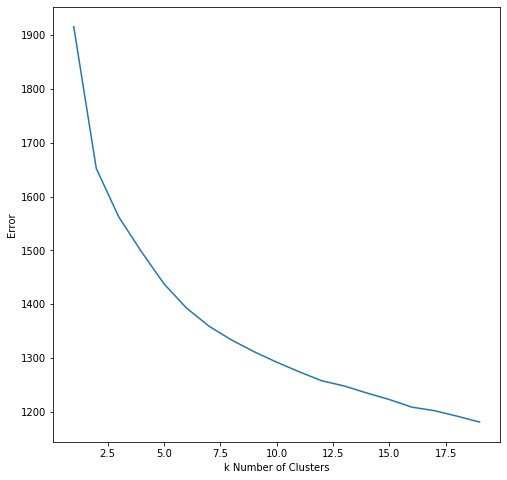

In [48]:
# see elbow plot
elbow_plot(layers,20)

In [49]:
# try 7 clusters
X_labels, _ = kmeans_fit(layers,7)
X_labels

array([6, 6, 4, ..., 6, 3, 1], dtype=int32)

(290,)

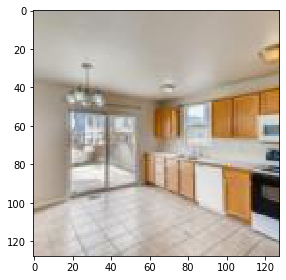

In [69]:
# plot cluster img
io.imshow(X_test[0])
test = np.where(X_labels==6)
test[0].shape



In [79]:
def cluster_plot(images, labels, select_label):
    subset_idx = np.where(labels == select_label)
    fig, axes = plt.subplots(4,4,figsize=(12,12))
    random_idx = np.random.choice(subset_idx[0],16,replace=False)
    for ax, idx in zip(axes.flatten(),random_idx):
        ax.imshow(images[idx])
    plt.show()

Cluster 1:



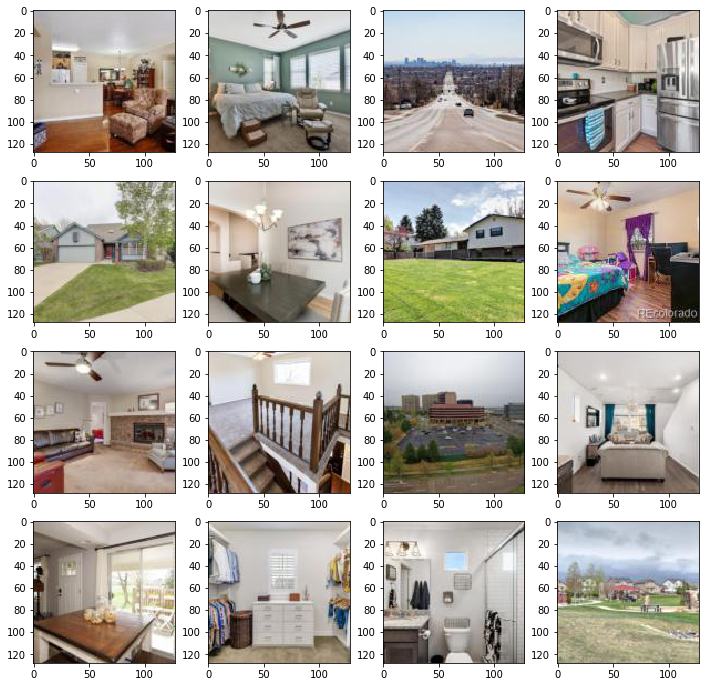

In [83]:
print('Cluster 1:\n')
cluster_plot(X_test, X_labels, 0)

Cluster 2:



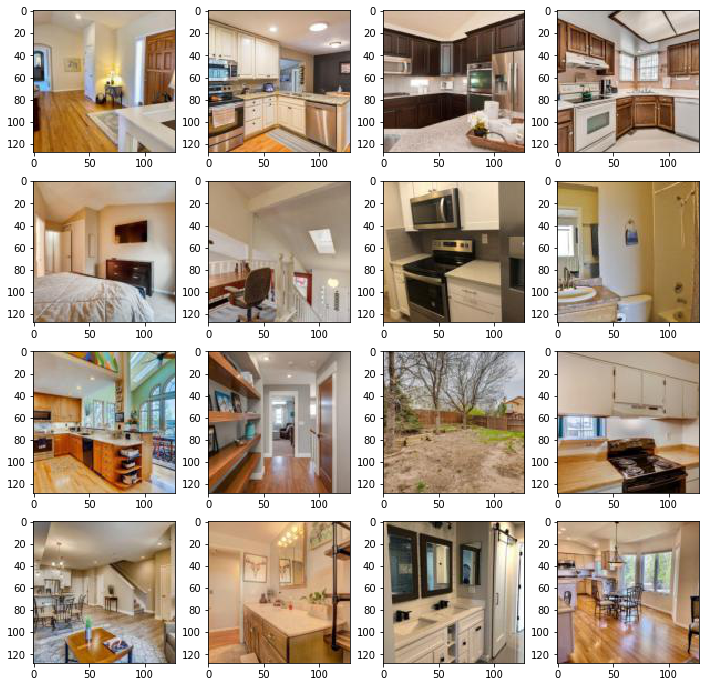

In [84]:
print('Cluster 2:\n')
cluster_plot(X_test, X_labels, 1)

Cluster 3:



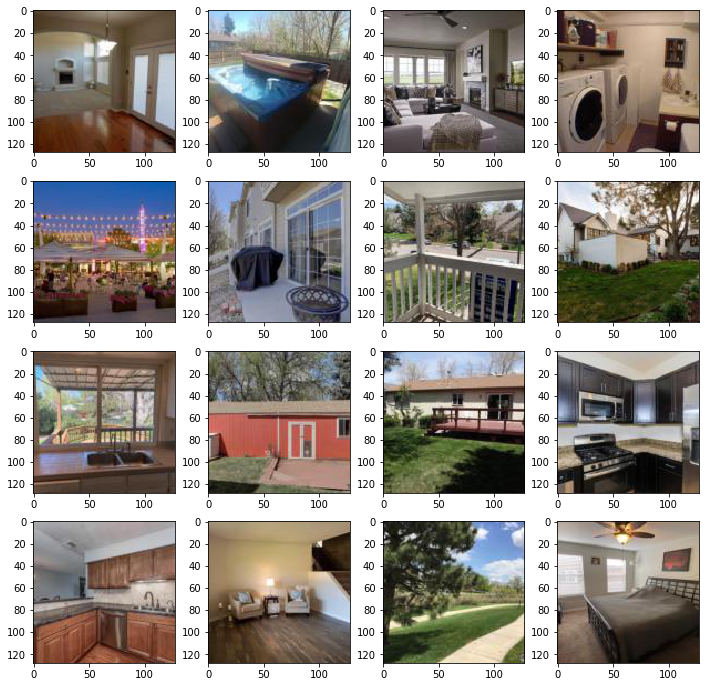

In [85]:
print('Cluster 3:\n')
cluster_plot(X_test, X_labels, 2)

Cluster 4:



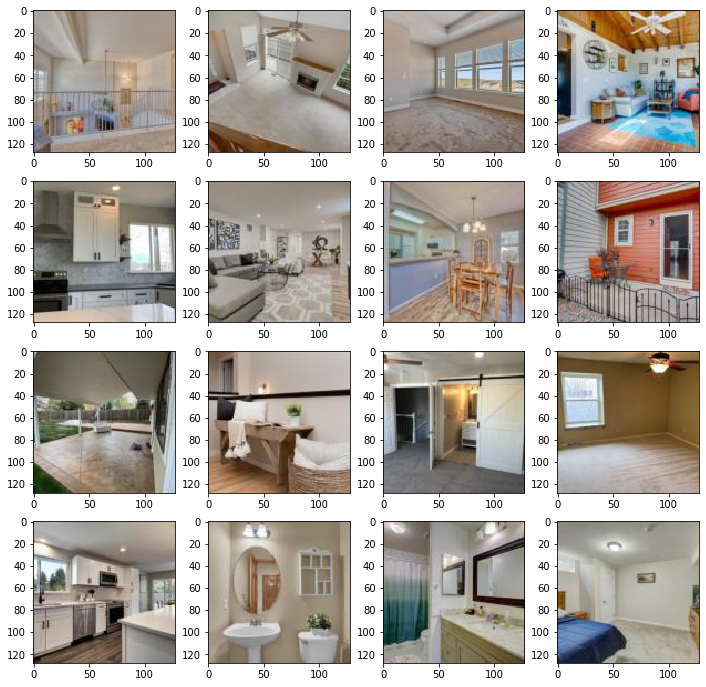

In [86]:
print('Cluster 4:\n')
cluster_plot(X_test, X_labels, 3)

Cluster 5:



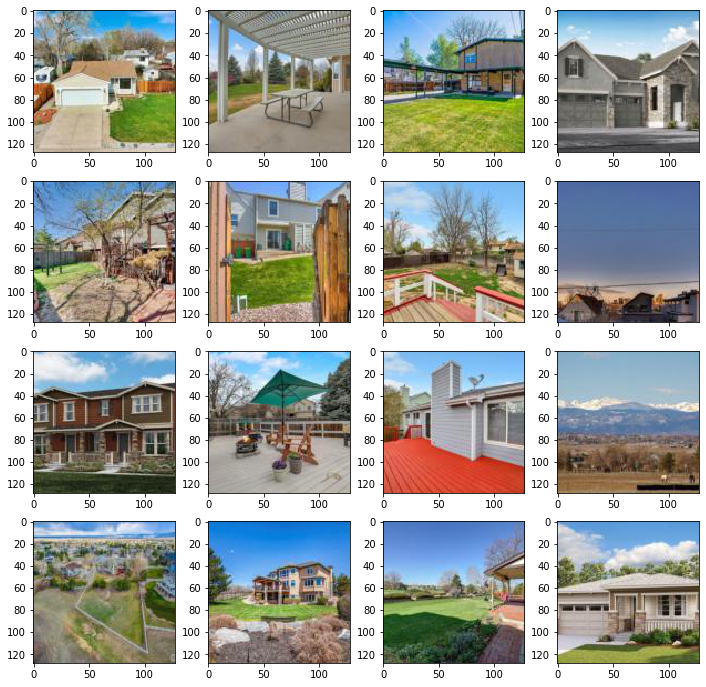

In [87]:
print('Cluster 5:\n')
cluster_plot(X_test, X_labels, 4)

Cluster 6:



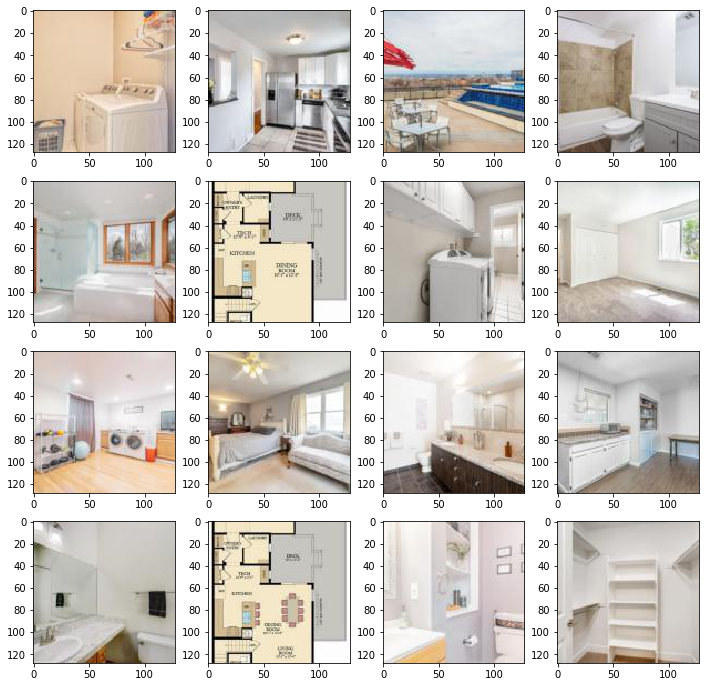

In [88]:
print('Cluster 6:\n')
cluster_plot(X_test, X_labels, 5)

Cluster 7:



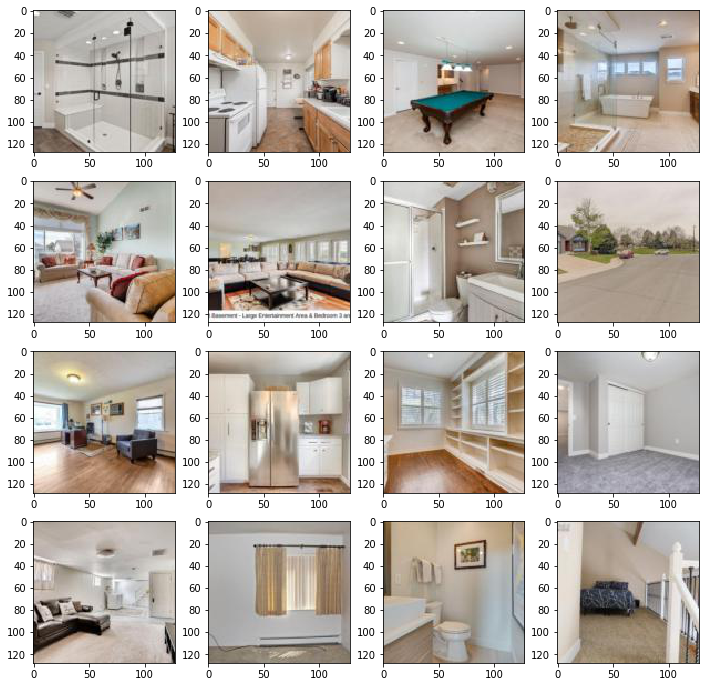

In [89]:
print('Cluster 7:\n')
cluster_plot(X_test, X_labels, 6)

ValueError: Found array with dim 4. Estimator expected <= 2.

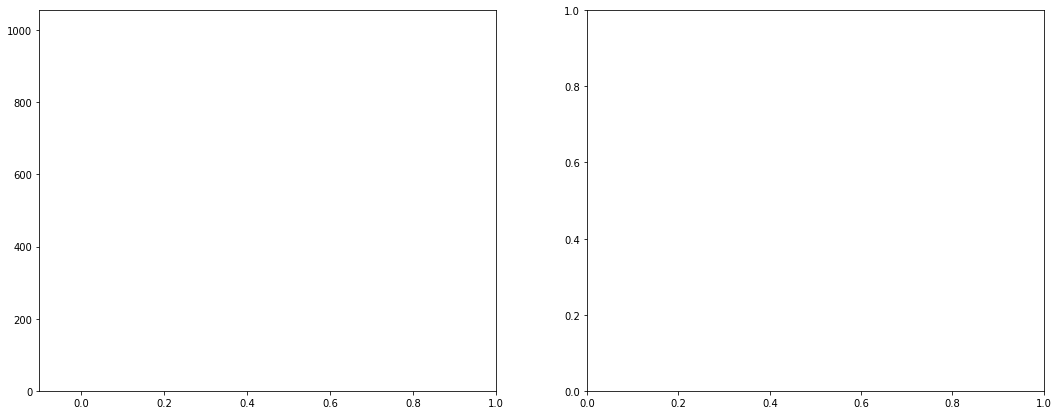

In [94]:
range_n_clusters = [0, 1, 2, 3, 4, 5, 6]

X = X_test
cluster_labels=X_labels

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #     # Initialize the clusterer with n_clusters value and a random generator
    #     # seed of 10 for reproducibility.
    #     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #     cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

(128, 128, 3)